In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from prefetch_generator import background

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, Callback
from keras.utils import to_categorical
import keras.backend as K

import tensorflow as tf
import keras.backend.tensorflow_backend as KTF
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config = config)
KTF.set_session(session)

Using TensorFlow backend.


In [2]:
class raw_sig(object):
    """
    信号基本信息
    """
    sig_name: str = ""  # 信号路径
    raw_data: np.array = np.array([])  # 信号原始数据
    sig_class: str = ""  # 信号类别
    fs: float = 0.  # 采样频率
    fd: float = 0.  # 码元速率
    fc: float = 0.  # 信号中心频率

    def __init__(self, data_path=None, sig_type="SAT", **kwargs):
        if data_path:
            self.sig_name = os.path.split(data_path)[-1]
            with open(data_path, "rb") as f:
                self.raw_data = np.frombuffer(f.read(), np.int16)
                
            self.sig_class = self.sig_name.split('_')[0]
            self.fs = np.float32(self.sig_name.split("_Fs")[-1].split("_Fc")[0])

            self.fc = np.float32(self.sig_name.split("Fc_")[-1].split("_Fd")[0])*1000
            self.fd = np.float32(self.sig_name.split("Fd_")[-1].split("_")[0])*1000
            
        self.all_classes = ['BPSK', 'QPSK', '8PSK', 'OQPSK', 'PI4QPSK',
                            '8QAM', '16QAM', '32QAM',
                            '16APSK', '32APSK',
                           "2FSK", "4FSK"]
        if sig_type == "USW":  # 超短波
            self.all_classes = ['BPSK', 'QPSK', '8PSK', 'OQPSK', 'PI4QPSK',
                                '8QAM', '16QAM', '32QAM', 
                                '16APSK', '32APSK', 
                                '2ASK', 
                                'CP2FSK', 'CP4FSK', 
                                'MSK', 'GMSK', 'C4FM', 
                                'FM_ST_CP2FSK', 'AM_ST_CP2FSK', 
                                'FM_ST_8PSK', 'AM_ST_8PSK',
                                'FM_MT_QPSK', 'AM_MT_QPSK']
        
        self.num_classes = len(self.all_classes)
        
        if "use_onehot_label" in kwargs:
            self._use_onehot_label_ = kwargs["use_onehot_label"]
        else:
            self._use_onehot_label_ = True
            
        if "resample" in kwargs:
            self.resample = kwargs["resample"]
        else:
            self.resample = False
            
        if "resample_length" in kwargs:
            self.resample_length = kwargs["resample_length"]
        else:
            self.resample_length = None
        
    @property
    def sig_label(self):
        label = self.all_classes.index(self.sig_class)
        #TODO: try
        if self._use_onehot_label_:
            tmp = np.zeros(self.num_classes)
            tmp[label] = 1.
            label = tmp
        return label
            
    @property        
    def base_IQ(self):
        """
        将射频信号转换成基带IQ信号
        ---------------
        return:
            @base_i: ndArray, 基带I
            @base_q: ndArray, 基带Q
        """
        
        b_i = self.raw_data*np.cos(2*np.pi*self.fc*np.arange(len(self.raw_data))/self.fs)
        b_q = self.raw_data*np.sin(2*np.pi*self.fc*np.arange(len(self.raw_data))/self.fs)
        
        # 滤波器参数
        L = 100 # np.floor(self.fs/self.fd)*10
        w = 1.25*self.fd/self.fs
        
        h = signal.firwin(L, w)
        
        base = signal.convolve(b_i+1j*b_q, h, "same")
        
        if self.resample:
            #TODO: try
            base = signal.resample(base, np.floor(len(base)*self.fs/self.fd))
            base = base[:self.resample_length]
        else:
            base = base[:50000]
        
        return np.real(base), np.imag(base)
    
    def __str__(self):
        return ("sig_name: {}\nsig_len: {}\nsig_class: {}\nFS: {}\nFC: {}\nFD: {}".format(self.sig_name, 
                                                                                       len(self.raw_data),
                                                                                       self.sig_class,
                                                                                       self.fs, self.fc, self.fd))

def Z_ScoreNormalization(x):
    """
    零均值归一化
    --------------
    parameter:
        @x: ndArray,
        @mu: float, 均值
        @sigma: float, 方差
    """
    mu = np.mean(x)
    sigma = np.std(x)
    
    return (x - mu) / sigma


# In[4]:


@background(max_prefetch=3)
def data_generator(file_paths, batch_size=128, input_len=50000):
    n = len(file_paths)
    i = 0
    
    while True:
        x_true = np.zeros((batch_size, input_len, 2))
        y_true = np.zeros((batch_size, raw_sig(file_paths[0]).num_classes))
        
        for idxx in range(batch_size):
            if i==0:
                np.random.shuffle(file_paths)
            sig = raw_sig(file_paths[i])
            try:
                data_i, data_q = sig.base_IQ
            except ValueError as e:
                print("ValueError", file_paths[i])
                break
            start = 0
            if input_len < 50000:
                start = np.random.randint(0, 50000-input_len)
            data_i = Z_ScoreNormalization(data_i[start : start + input_len])
            data_q = Z_ScoreNormalization(data_q[start : start + input_len])
            
            x_true[idxx, :, 0] = data_i
            x_true[idxx, :, 1] = data_q
            y_true[idxx] = sig.sig_label
            
            i = (i+1) % n
            
        yield x_true, y_true


In [4]:
def amc_net(input_len=None):
    inputs = Input((input_len, 2), name="inputs")
    x = Conv1D(filters=64, kernel_size=20, activation="relu", name="conv1")(inputs)
    x = Conv1D(filters=128, kernel_size=10, activation="relu", name="conv2")(x)
    x = Dropout(rate=0.3, name="dropout3")(x)
    x = Conv1D(filters=128, kernel_size=10, activation="relu", name="conv4")(x)
    x = Conv1D(filters=128, kernel_size=10, activation="relu", name="conv5")(x)
    x = GlobalAveragePooling1D(name="GLPooling6")(x)
    x = Dense(units=128, activation="relu", name="dense7")(x)
    x = Dense(units=len(raw_sig().all_classes), activation="softmax", name="dense8")(x)
    
    model = Model(inputs=inputs, outputs=x)
    
    return model

def build_model(model):
    opt = Adam(lr=0.002, epsilon=1e-08)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt)
    
    return model

In [5]:
%matplotlib inline
from IPython.display import display, clear_output
import time

class realTimePlot(Callback):
    def __init__(self, title=None):
        if title is None:
            self.title = "RealTime training Plot"
        else:
            self.title = title
            
        self.fig = plt.figure(figsize=(12, 10))
        self.ax = self.fig.add_subplot(211)
        self.ax1 = self.fig.add_subplot(212)
        self.ax.set_title(self.title, color="k", fontsize=16)
        self.ax.set_ylabel("accuracy", fontsize = 20)
        self.ax1.set_ylabel("loss", fontsize = 20)
        self.ax.grid(True)
        self.ax1.grid(True)
        self.ax1.set_xlabel("Epochs", fontsize=16)
        self.ixx = 1
    
    def on_train_begin(self, logs={}):
        self.losses = []
        self.acces = []
        self.val_loss=[]
        self.val_acc=[]

    def on_epoch_end(self, epoch, logs={}):
#         if self.batches % 20 == 0:
        self.losses.append(logs.get('loss'))
        self.acces.append(logs.get('acc'))
        self.val_acc.append(logs.get("val_acc"))
        self.val_loss.append(logs.get("val_loss"))

        self.ax1.plot(self.losses, 'r-', label="train_loss")
        self.ax1.plot(self.val_loss, 'b-', label="val_loss")

        self.ax.plot(self.acces, 'r-', label="train_acc")
        self.ax.plot(self.val_acc, 'b-', label="val_acc")
        if self.ixx:
            self.ixx -= 1
            self.ax.legend(fontsize=14)
            self.ax1.legend(fontsize=14)

        clear_output(wait=True)
        display(self.fig)
        
    def on_train_end(self, logs=None):
        plt.close()

In [6]:
def train(input_len=50000, batch_size=16, epochs=5):
    real_epochs_num = 8192  # 实际每个epochs训练的信号数量
    train_path = "/data/all_sigdata_60g/"
    val_path = "/data/all_sigdata60g_val/"

    train_files = [os.path.join(train_path, item) for item in os.listdir(train_path)]
    val_files = [os.path.join(val_path, item) for item in os.listdir(val_path)]
    num_train = len(train_files)
    num_val = len(val_files)
    
    train_steps = real_epochs_num//batch_size
    val_steps = train_steps//4
    
    real_epochs = epochs*(num_train//real_epochs_num +1)
    
    data_train_gener = data_generator(train_files, batch_size=batch_size, input_len=input_len)
    data_val_gener = data_generator(val_files, batch_size=batch_size, input_len=input_len)

    rtp = realTimePlot(title="AMC traininig process for input_length={}".format(input_len))
    
    model_path = "training_logs/models_60g_{}".format(input_len)
    if not os.path.exists(model_path):
        os.makedirs(model_path)
    
    cheack_path = ModelCheckpoint(model_path + "/best-ep{epoch:03d}-acc{acc:.3f}-val_acc{val_acc:.3f}.h5",
                                 save_best_only=True)
    model = build_model(amc_net())
    history = model.fit_generator(
                        data_train_gener,
                        steps_per_epoch=train_steps,
                        validation_data=data_val_gener,
                        validation_steps=val_steps,
                        epochs=real_epochs,
                        callbacks=[rtp, cheack_path])
    model.save(model_path +  "/amc_final_{}.h5".format(input_len))
    np.save("training_logs//train_log_60g_{}.npy".format(input_len), history.history)


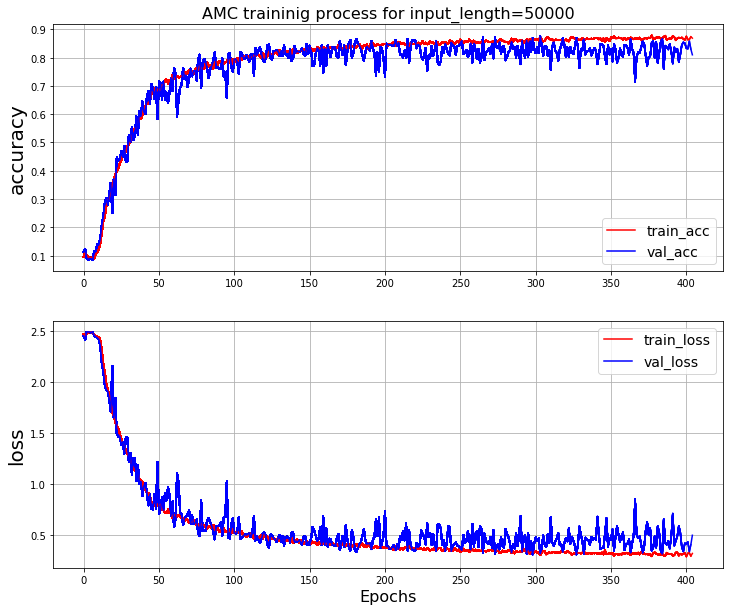

In [7]:
train()